In [134]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score,precision_recall_curve, auc, f1_score, confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

In [120]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [121]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [122]:
X_train.head()
len(X_train)

49000

In [114]:
# Custom SmokingImputer (Returns 2D output)
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

In [115]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        # Split and filter out empty sets or single-underscore terms
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        # Remove empty sets by converting to list of non-empty sets
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [116]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [117]:
# HighCorrelationRemover with preserved feature names
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [123]:
# Define columns and encoders
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

# First preprocessor: Handle imputation and basic transformations
preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        #('smokingImputer', SmokingImputer(), ['smoking_history']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Second preprocessor: Encode categorical variables with correct column names
preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Single pipeline combining all steps
pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

# Fit and transform training data
X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

# Transform test data
X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

# Print the final column names
print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

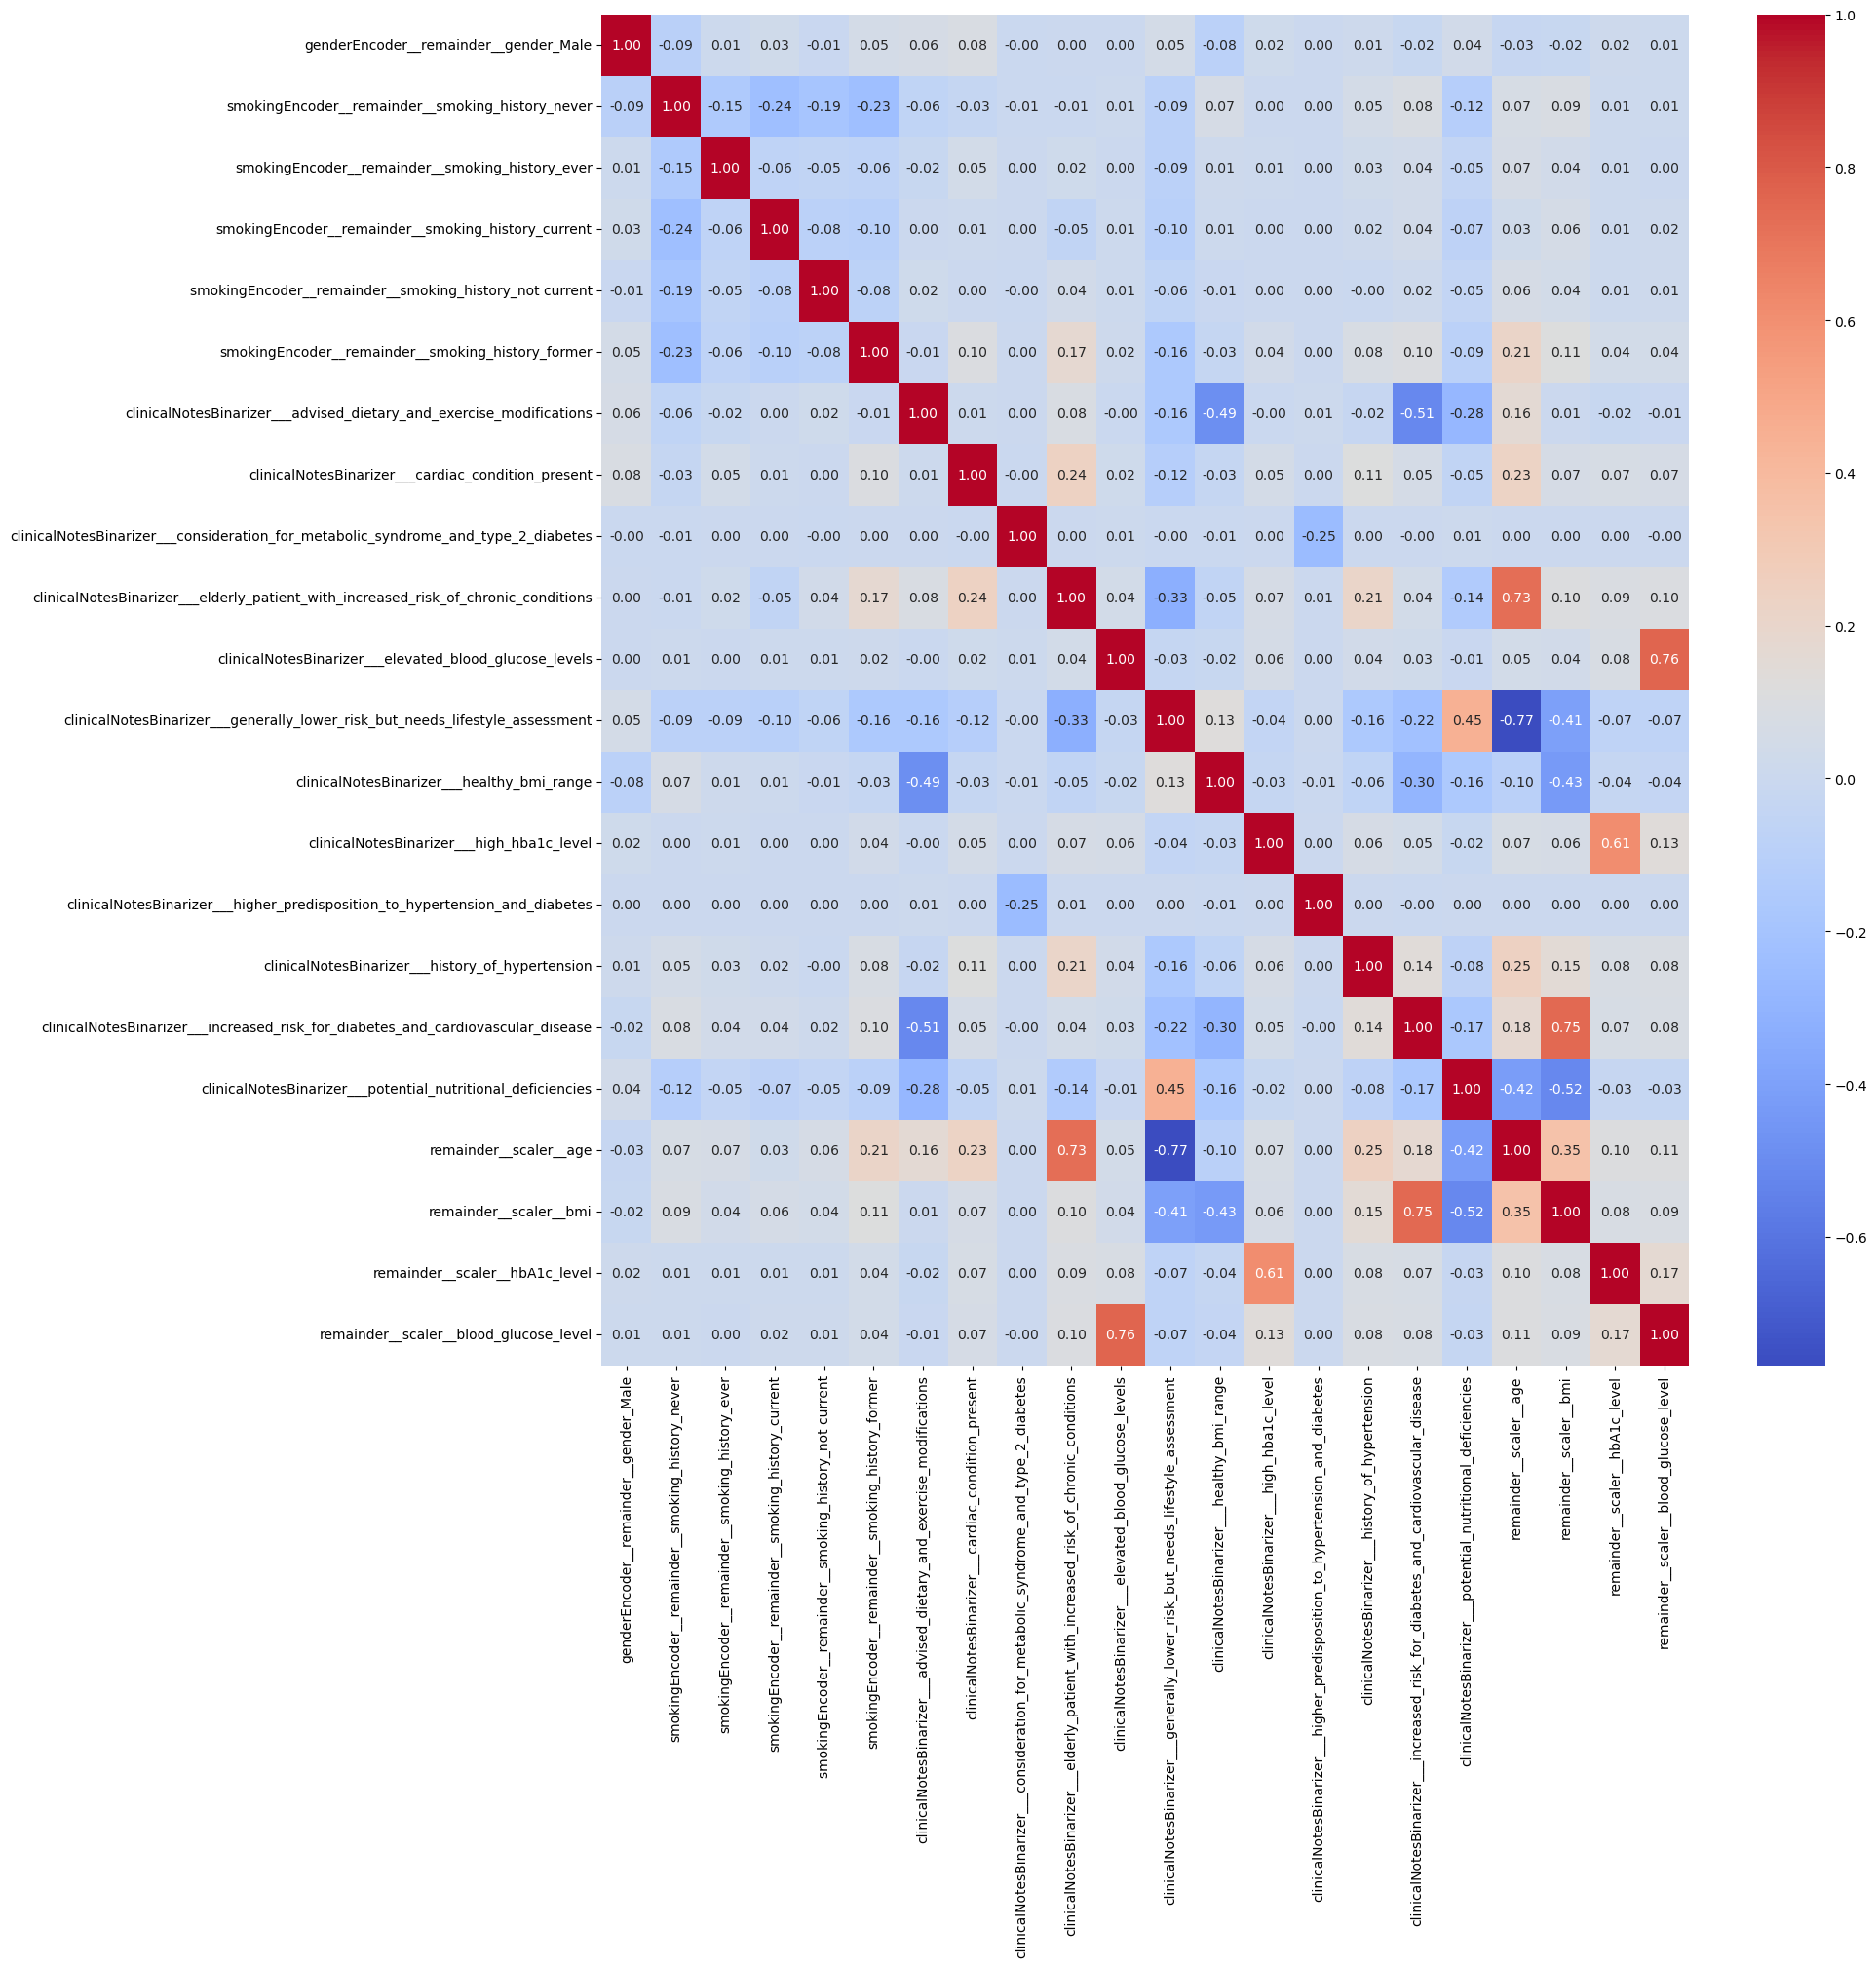

In [10]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [11]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    # Predictions and probabilities
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]  # Probabilities for training
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1]   # Probabilities for test
    
    # Precision-Recall Curves
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    # Evaluate the model
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  # PR-AUC for training
    test_pr_auc = auc(recall_test, precision_test)     # PR-AUC for test
    train_f1 = f1_score(y_train, y_train_pred)         # F1 score for training
    test_f1 = f1_score(y_test, y_test_pred)            # F1 score for test
    
    # Print results
    print("\nModel Performance:")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_f1, test_f1)

In [12]:
model = LogisticRegression()
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training F1 Score: 0.7359
Test F1 Score: 0.7387
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]


(0.810778737724598,
 0.8130076074145506,
 0.8254827428707748,
 0.8309939154416266,
 0.7358517062210364,
 0.7387328543435663)

In [13]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']


In [14]:
model = LogisticRegression()
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training ROC-AUC: 0.8093
Test ROC-AUC: 0.8145
Training PR-AUC: 0.8221
Test PR-AUC: 0.8295
Training F1 Score: 0.7331
Test F1 Score: 0.7413
Test Confusion Matrix:
 [[19071   144]
 [  649  1136]]


(0.8092712494833999,
 0.8144602103136336,
 0.8220768245342833,
 0.8295363941876387,
 0.7330990864371048,
 0.7412724306688417)

In [15]:
model = LogisticRegression(penalty='l1', solver='saga')
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8112
Test ROC-AUC: 0.8136
Training PR-AUC: 0.8256
Test PR-AUC: 0.8313
Training F1 Score: 0.7361
Test F1 Score: 0.7398
Test Confusion Matrix:
 [[19070   145]
 [  652  1133]]


(0.8112143217942915,
 0.8135938528416832,
 0.8255561410073182,
 0.8312660670274205,
 0.7361481273670921,
 0.7397975840679073)

In [104]:
rfe = RFE(estimator = LogisticRegression(penalty='l1', solver='saga'), n_features_to_select=16, verbose=1)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

Fitting estimator with 18 features.
Fitting estimator with 17 features.

Model Performance:
Training ROC-AUC: 0.8092
Test ROC-AUC: 0.8154
Training PR-AUC: 0.8225
Test PR-AUC: 0.8298
Training F1 Score: 0.7327
Test F1 Score: 0.7437
Test Confusion Matrix:
 [[19076   139]
 [  646  1139]]


(0.8092266414762627,
 0.8154306531355712,
 0.82250324667425,
 0.8298316404591906,
 0.7326871751650512,
 0.7437153117858308)

In [38]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
model = LogisticRegression()
scores_model(X_train_sel, X_test_sel, model)



Model Performance:
Training ROC-AUC: 0.8059
Test ROC-AUC: 0.8106
Training PR-AUC: 0.8168
Test PR-AUC: 0.8235
Training F1 Score: 0.7276
Test F1 Score: 0.7382
Test Confusion Matrix:
 [[19084   131]
 [  664  1121]]


(0.8058541449366632,
 0.8105968070288225,
 0.816846272549865,
 0.8234742200604438,
 0.727580372250423,
 0.73822851498189)

The results with Variance Treshold are worse than only Logistic Regression

In [131]:
neighbors = np.arange(1,12)
train_roc_auc = {}
test_roc_auc = {}
train_f1 = {}
test_f1 = {}
train_pr_auc = {}
test_pr_auc = {}
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    train_roc_auc[neighbor], test_roc_auc[neighbor], train_pr_auc[neighbor], test_pr_auc[neighbor], train_f1[neighbor], test_f1[neighbor] = scores_model(X_train_transformed_df, X_test_transformed_df, knn)


Model Performance:
Training ROC-AUC: 0.9996
Test ROC-AUC: 0.8118
Training PR-AUC: 0.9992
Test PR-AUC: 0.6847
Training F1 Score: 0.9992
Test F1 Score: 0.6694
Test Confusion Matrix:
 [[18690   525]
 [  623  1162]]

Model Performance:
Training ROC-AUC: 0.8175
Test ROC-AUC: 0.7716
Training PR-AUC: 0.9584
Test PR-AUC: 0.7503
Training F1 Score: 0.7768
Test F1 Score: 0.6858
Test Confusion Matrix:
 [[19126    89]
 [  807   978]]

Model Performance:
Training ROC-AUC: 0.8521
Test ROC-AUC: 0.8009
Training PR-AUC: 0.9334
Test PR-AUC: 0.7728
Training F1 Score: 0.8048
Test F1 Score: 0.7035
Test Confusion Matrix:
 [[18980   235]
 [  689  1096]]

Model Performance:
Training ROC-AUC: 0.7944
Test ROC-AUC: 0.7731
Training PR-AUC: 0.9158
Test PR-AUC: 0.7837
Training F1 Score: 0.7348
Test F1 Score: 0.6913
Test Confusion Matrix:
 [[19141    74]
 [  803   982]]

Model Performance:
Training ROC-AUC: 0.8155
Test ROC-AUC: 0.7952
Training PR-AUC: 0.9042
Test PR-AUC: 0.7899
Training F1 Score: 0.7559
Test F1 Scor

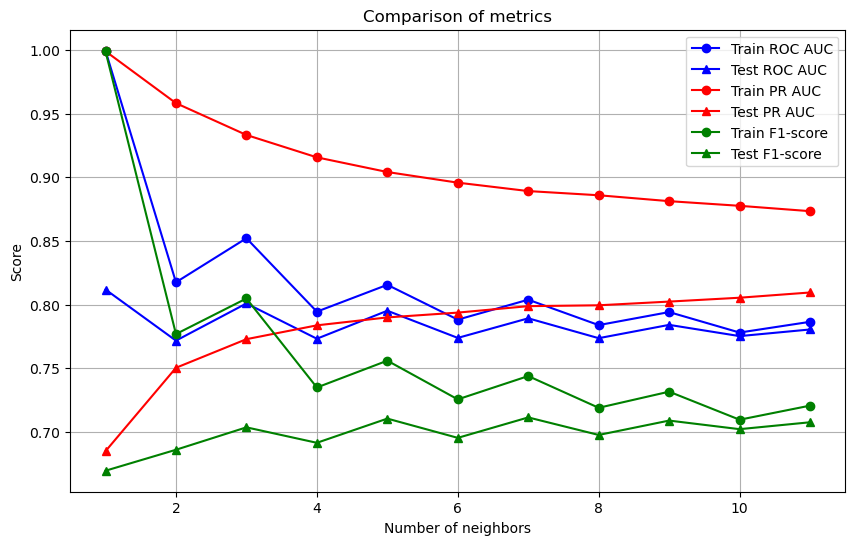

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(neighbors, train_roc_auc.values(), label="Train ROC AUC", marker='o', linestyle='-', color = 'blue')
plt.plot(neighbors, test_roc_auc.values(), label="Test ROC AUC", marker='^', linestyle='-', color = 'blue')

plt.plot(neighbors, train_pr_auc.values(), label="Train PR AUC", marker='o', linestyle='-', color = 'red')
plt.plot(neighbors, test_pr_auc.values(), label="Test PR AUC", marker='^', linestyle='-', color = 'red')

plt.plot(neighbors, train_f1.values(), label="Train F1-score", marker='o', linestyle='-', color = 'green')
plt.plot(neighbors, test_f1.values(), label="Test F1-score", marker='^', linestyle='-', color = 'green')

plt.xlabel("Number of neighbors")
plt.ylabel("Score")
plt.title("Comparison of metrics")
plt.legend()
plt.grid(True)

plt.show()

It seems that the best number of neighbors is 7.

In [133]:
model = KNeighborsClassifier(n_neighbors = 7)
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8038
Test ROC-AUC: 0.7892
Training PR-AUC: 0.8892
Test PR-AUC: 0.7988
Training F1 Score: 0.7438
Test F1 Score: 0.7113
Test Confusion Matrix:
 [[19112   103]
 [  743  1042]]


(0.8038323526131764,
 0.7891965529381152,
 0.8892429213467883,
 0.7987520894198481,
 0.7437847323778882,
 0.7112627986348122)

RandomisedSearchCV for DecisionTreeClassifier

In [18]:
def pr_auc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)
    
param_dist = {
    'max_depth': [3, 5, 6, 7, 10, 15, None],
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
scoring = {
    'roc_auc': 'roc_auc', 
    'f1_score': 'f1',  
    'pr_auc': make_scorer(pr_auc_scorer) 
}
# musiałam wybrać jedną do refitowania- aucroc??
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='roc_auc')

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)

Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 0.05, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}

Best model scores:

Model Performance:
Training ROC-AUC: 0.7157
Test ROC-AUC: 0.7122
Training PR-AUC: 0.5795
Test PR-AUC: 0.5818
Training F1 Score: 0.5044
Test F1 Score: 0.5006
Test Confusion Matrix:
 [[18544   671]
 [  965   820]]


(0.7157144825143172,
 0.7122315592903827,
 0.5795085627817211,
 0.5817525909990281,
 0.5044064282011405,
 0.5006105006105006)

In [19]:
lr = LogisticRegression()

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=0.1, random_state=2, max_features = 15)
scores_model(X_train_transformed_df, X_test_transformed_df, dt)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]


Model Performance:
Training ROC-AUC: 0.5000
Test ROC-AUC: 0.5000
Training PR-AUC: 0.4444
Test PR-AUC: 0.4519
Training F1 Score: 0.0000
Test F1 Score: 0.0000
Test Confusion Matrix:
 [[19215     0]
 [ 1785     0]]


Voting Classifier

In [ ]:
for clf_name, model in classifiers:    
    print(clf_name)
    scores_model(X_train_transformed_df, X_test_transformed_df, model)
vc = VotingClassifier(estimators=classifiers, voting='soft') 
print('Voting classifier:')
scores_model(X_train_transformed_df, X_test_transformed_df, vc)

Logistic Regression

Model Performance:
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training F1 Score: 0.7359
Test F1 Score: 0.7387
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]
K Nearest Neighbours

Model Performance:
Training ROC-AUC: 0.7941
Test ROC-AUC: 0.7840
Training PR-AUC: 0.8813
Test PR-AUC: 0.8023
Training F1 Score: 0.7315
Test F1 Score: 0.7088
Test Confusion Matrix:
 [[19140    75]
 [  764  1021]]
Classification Tree

Model Performance:
Training ROC-AUC: 0.5000
Test ROC-AUC: 0.5000
Training PR-AUC: 0.4444
Test PR-AUC: 0.4519
Training F1 Score: 0.0000
Test F1 Score: 0.0000
Test Confusion Matrix:
 [[19215     0]
 [ 1785     0]]
Voting classifier:

Model Performance:
Training ROC-AUC: 0.7791
Test ROC-AUC: 0.7818
Training PR-AUC: 0.8473
Test PR-AUC: 0.8166
Training F1 Score: 0.7128
Test F1 Score: 0.7143
Test Confusion Matrix:
 [[19184    31]
 [  776  1009]]


(0.7791346046615368,
 0.7818263917588893,
 0.8472742606397744,
 0.8166266778106218,
 0.7127773527161438,
 0.7143362831858407)

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
scores_model(X_train_transformed_df, X_test_transformed_df, rf)


Model Performance:
Training ROC-AUC: 0.9991
Test ROC-AUC: 0.8484
Training PR-AUC: 1.0000
Test PR-AUC: 0.8734
Training F1 Score: 0.9990
Test F1 Score: 0.8079
Test Confusion Matrix:
 [[19157    58]
 [  536  1249]]
[0.01249195 0.00924862 0.0043785  0.00557887 0.0054011  0.00696677
 0.00311757 0.010292   0.01010376 0.01694572 0.01829683 0.00281089
 0.00230038 0.04169168 0.0101185  0.01293852 0.00891687 0.00057726
 0.09344972 0.09545655 0.32664727 0.30227067]


In [ ]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9891
Test ROC-AUC: 0.8534
Training PR-AUC: 0.9996
Test PR-AUC: 0.8659
Training F1 Score: 0.9884
Test F1 Score: 0.8033
Test Confusion Matrix:
 [[19105   110]
 [  513  1272]]


(0.9891287662606026,
 0.8534401738837611,
 0.9995933266535303,
 0.8659038798417484,
 0.9883579917535775,
 0.803283864856331)

In [129]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9955
Test ROC-AUC: 0.8498
Training PR-AUC: 1.0000
Test PR-AUC: 0.8639
Training F1 Score: 0.9954
Test F1 Score: 0.8079
Test Confusion Matrix:
 [[19148    67]
 [  530  1255]]


(0.9955470712875313,
 0.8497971866342166,
 0.9999575912792479,
 0.8639053906888271,
 0.9954183747287195,
 0.8078532346314773)

In [100]:
rf = RandomForestClassifier()
scores_model(X_train_transformed_df, X_test_transformed_df, rf)
print(rf.feature_importances_)
mask = rf.feature_importances_ > 0.06
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9975
Test ROC-AUC: 0.8494
Training PR-AUC: 1.0000
Test PR-AUC: 0.8699
Training F1 Score: 0.9974
Test F1 Score: 0.8084
Test Confusion Matrix:
 [[19153    62]
 [  532  1253]]
[0.01230052 0.0026678  0.00941552 0.0103688  0.01465758 0.01563726
 0.00190939 0.00219166 0.03829256 0.00989696 0.01301455 0.0129275
 0.00867397 0.00044252 0.09360928 0.10296533 0.35805988 0.29296893]

Model Performance:
Training ROC-AUC: 0.9811
Test ROC-AUC: 0.8527
Training PR-AUC: 0.9986
Test PR-AUC: 0.8620
Training F1 Score: 0.9800
Test F1 Score: 0.8008
Test Confusion Matrix:
 [[19098   117]
 [  515  1270]]


(0.9810743969719036,
 0.852697800431648,
 0.9985825733862295,
 0.8620400247096582,
 0.9799511002444988,
 0.8007566204287516)

In [124]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=8, verbose=1, step=5)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.

Model Performance:
Training ROC-AUC: 0.9854
Test ROC-AUC: 0.8542
Training PR-AUC: 0.9992
Test PR-AUC: 0.8608
Training F1 Score: 0.9843
Test F1 Score: 0.8031
Test Confusion Matrix:
 [[19100   115]
 [  510  1275]]


(0.9853849736615957,
 0.8541504033307312,
 0.9991736342961607,
 0.8608129615133874,
 0.9843008397225265,
 0.8031496062992126)

[0.26026325 0.43996261 0.5796008  0.70175682 0.75437267 0.79355488
 0.82689059 0.85720648 0.87952059 0.89768802 0.91357461 0.92823281
 0.94141713 0.9541003  0.96523757 0.97465769 0.98210941 0.98733193
 0.99207206 0.99633129 1.         1.        ]


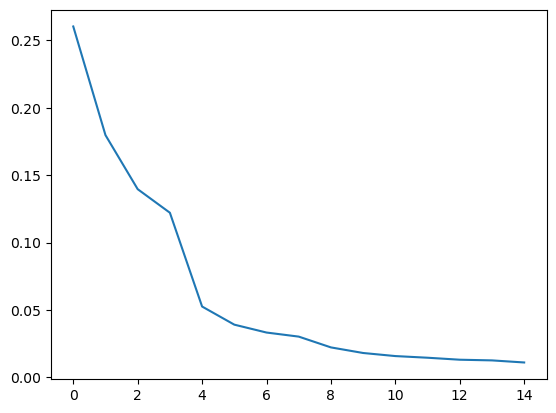

In [150]:
pipelinePCA = Pipeline([
    ('reducer', PCA(n_components=15)),
    ('classifier', RandomForestClassifier())
])
pca = PCA()
pca.fit_transform(X_train_transformed_df, y_train)
print(pca.explained_variance_ratio_.cumsum())
pipelinePCA.fit(X_train_transformed, y_train)
plt.plot(pipelinePCA['reducer'].explained_variance_ratio_)

In [152]:
pipelinePCA2 = Pipeline([
    ('reducer', PCA(n_components=5)),
    ('classifier', RandomForestClassifier())
])
scores_model(X_train_transformed_df, X_test_transformed_df, pipelinePCA2)


Model Performance:
Training ROC-AUC: 0.9990
Test ROC-AUC: 0.8441
Training PR-AUC: 1.0000
Test PR-AUC: 0.8599
Training F1 Score: 0.9990
Test F1 Score: 0.7991
Test Confusion Matrix:
 [[19144    71]
 [  550  1235]]


(0.9990396158463386,
 0.8440908603878711,
 0.9999985884924956,
 0.8599309434906902,
 0.9990386926219659,
 0.7990941442898738)